# Projeto unidade 2

Neste projeto, iremos utilizar um dataset do `torchvision` para treinar uma CNN. Utilizando um modelo similar ao LeNet, treinaremos uma CNN de classificação de roupas baseado no dataset FashionMNIST, que contém diversas peças de roupa distintas.

Para isso, usaremos uma rede similar à `LeNet`, com a classe `Architecture` utilizada em sala.


In [9]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.v2 import Compose, Normalize, ToPILImage, ToImage, Resize, ToDtype, ToTensor
from torchvision import datasets

from torch.utils.data import random_split, WeightedRandomSampler

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import os.path as pth

## Classe Architecture

In [12]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

        # for hook purposes
        self.handles = {}
        self.visualization = {}

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename, weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # weights -> (channels_out (filter), channels_in, H, W)
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels,
                                        figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}',
                        title='Channel'
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1
                  for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images,
                                figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] \
                              if is_vector \
                              else f'{layers[i]}\nfil#{row-start_row}',
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
              isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)


    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

## Baixar os datasets da FashionMNIST

In [4]:
# Transformações
transform = Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5,), (0.5,))
])

# Download e carregamento
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 252kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.10MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.55MB/s]


## Dataloaders
Vamos criar dataloaders e especificar o vetor _target_ para a classificação (`classes`)

In [5]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Classes do Fashion-MNIST
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Tamanho do dataset de treinamento: {len(train_dataset)}")
print(f"Tamanho do dataset de teste: {len(test_dataset)}")
print(f"Classes: {classes}")

Tamanho do dataset de treinamento: 60000
Tamanho do dataset de teste: 10000
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Modelo de treinamento LeNet-like
Para esta atividade, iremos utilizar um modelo similar ao LeNet para fazer o treinamento de nossa CNN.

Veja que estamos adicionando camadas de dropout. Isto foi adicionado porque houve overfitting inicialmente.

In [6]:
lenet = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet.add_module('C1', nn.Conv2d(in_channels=1, out_channels=6,
                                  kernel_size=5, padding=2))
lenet.add_module('relu1', nn.ReLU())
lenet.add_module('S2', nn.MaxPool2d(kernel_size=2))

# dropout
lenet.add_module('dropout1', nn.Dropout2d(0.25))

# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet.add_module('C3', nn.Conv2d(in_channels=6, out_channels=16,
                                  kernel_size=5))
lenet.add_module('relu2', nn.ReLU())
lenet.add_module('S4', nn.MaxPool2d(kernel_size=2))

# dropout
lenet.add_module('dropout2', nn.Dropout2d(0.25))

# Block 3: 16@5x5 -> 120@1x1
lenet.add_module('C5', nn.Conv2d(in_channels=16, out_channels=120,
                                  kernel_size=5))
lenet.add_module('relu3', nn.ReLU())

# Flattening
lenet.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet.add_module('F6', nn.Linear(in_features=120, out_features=84))
lenet.add_module('relu4', nn.ReLU())

lenet.add_module('dropout3', nn.Dropout(0.5))

# Output Layer
lenet.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

## Treinar modelo

In [13]:
# Função de perda própria para classificação (entropia-cruzada).
loss_fn = nn.CrossEntropyLoss()

# Otimizador
optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001)

# Instanciar nossa arquitetura com o modelo, a função de perda e o otimizador
arch = Architecture(lenet, loss_fn, optimizer)
arch.set_loaders(train_loader, val_loader)

# Contar parâmetros
n_params = arch.count_parameters()
print(f"Total de parâmetros: {n_params:,}")

# Treinar
if (pth.exists("modelo_treinado.pth")):
    arch.load_checkpoint("modelo_treinado.pth")
else:
    arch.train(n_epochs=20, seed=42)
    print("Treinamento concluído!")
    arch.save_checkpoint('modelo_treinado.pth')

Total de parâmetros: 61,706


## Perdas

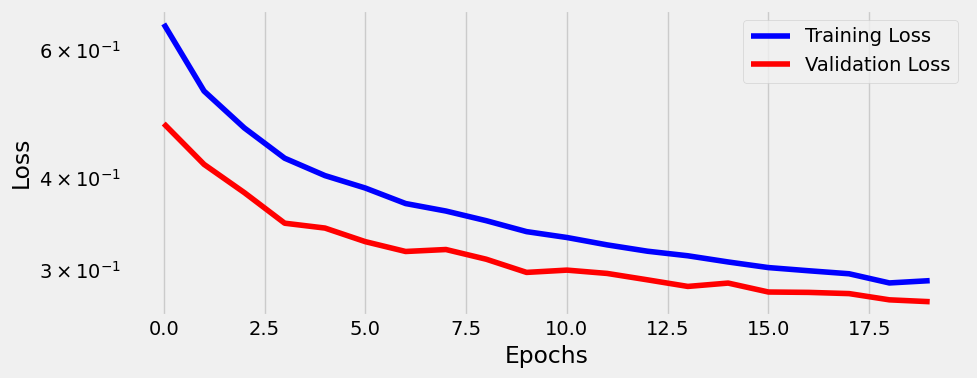

In [56]:

fig = arch.plot_losses()
plt.savefig('img/training_losses.png', dpi=300, bbox_inches='tight')
plt.show()

## Acurácias

In [52]:
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score
)

def get_predictions(arch, data_loader):
    arch.model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(arch.device)
            y_batch = y_batch.to(arch.device)

            outputs = arch.model(x_batch)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    arch.model.train()

    return np.array(all_labels), np.array(all_predictions)


def avaliar_modelo(model_trainer, data_loader, class_names, filename):

    y_true, y_pred = get_predictions(model_trainer, data_loader)

    report = classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=4
    )
    print(report)

    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    fig, axes = plt.subplots(1, 1, figsize=(10, 8))

    sns.heatmap(
        cm_percent,
        annot=True,
        fmt='.1f',
        cmap='RdYlGn',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=axes,
        vmin=0,
        vmax=100,
        cbar_kws={'label': 'Percentual (%)'}
    )
    axes.set_title('Matriz de Confusão',
                      fontsize=14, fontweight='bold')
    axes.set_ylabel('Classe Real', fontsize=12)
    axes.set_xlabel('Classe Predita', fontsize=12)

    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()

              precision    recall  f1-score   support

 T-shirt/top     0.8600    0.8480    0.8540      1000
     Trouser     0.9959    0.9770    0.9864      1000
    Pullover     0.8485    0.8400    0.8442      1000
       Dress     0.8837    0.9350    0.9086      1000
        Coat     0.8233    0.8480    0.8355      1000
      Sandal     0.9826    0.9620    0.9722      1000
       Shirt     0.7415    0.6970    0.7186      1000
     Sneaker     0.9295    0.9760    0.9522      1000
         Bag     0.9733    0.9830    0.9781      1000
  Ankle boot     0.9764    0.9530    0.9646      1000

    accuracy                         0.9019     10000
   macro avg     0.9015    0.9019    0.9014     10000
weighted avg     0.9015    0.9019    0.9014     10000



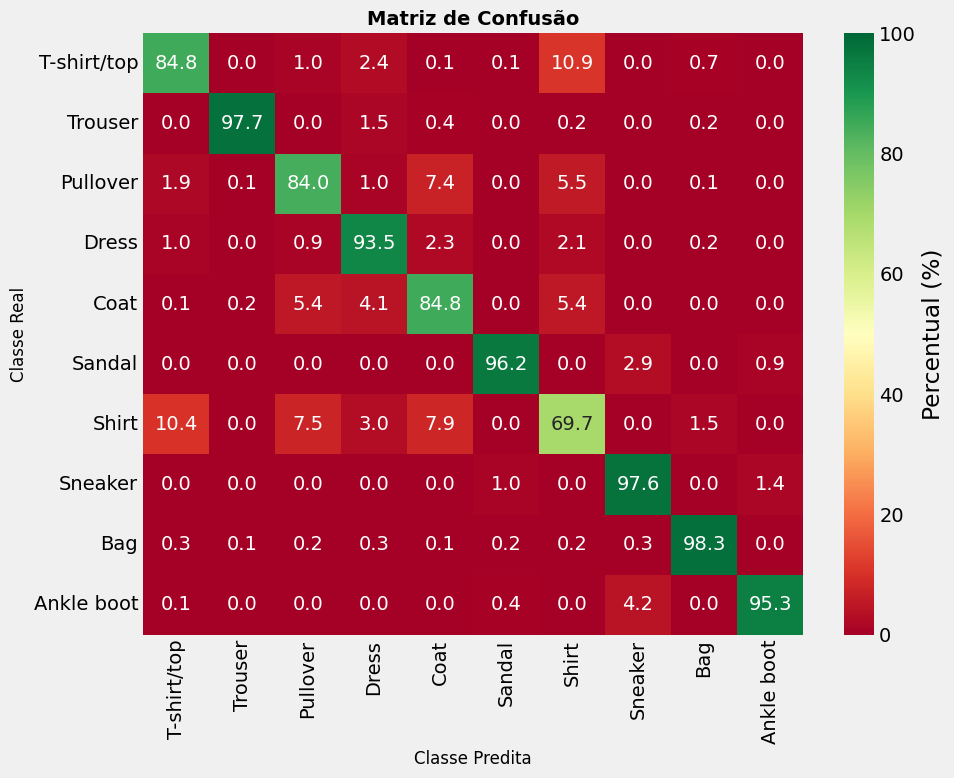

              precision    recall  f1-score   support

 T-shirt/top     0.8776    0.8690    0.8733      6000
     Trouser     0.9968    0.9847    0.9907      6000
    Pullover     0.8819    0.8602    0.8709      6000
       Dress     0.8881    0.9542    0.9200      6000
        Coat     0.8482    0.8725    0.8602      6000
      Sandal     0.9949    0.9758    0.9853      6000
       Shirt     0.7921    0.7448    0.7677      6000
     Sneaker     0.9491    0.9822    0.9654      6000
         Bag     0.9870    0.9900    0.9885      6000
  Ankle boot     0.9780    0.9630    0.9704      6000

    accuracy                         0.9196     60000
   macro avg     0.9194    0.9196    0.9192     60000
weighted avg     0.9194    0.9196    0.9192     60000



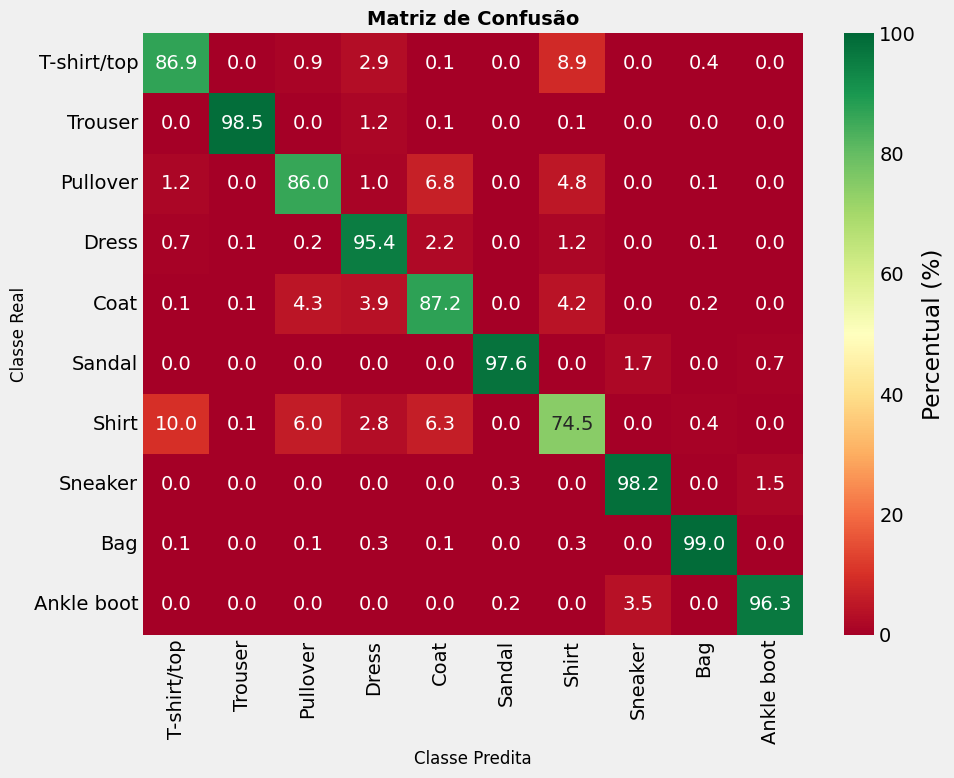

In [55]:
# Avaliar no conjunto de validação
val_metrics = avaliar_modelo(arch, val_loader, classes, 'img/confusion_matrix_val.png')

# Avaliar no conjunto de treino também
train_metrics = avaliar_modelo(arch, train_loader, classes, 'img/confusion_matrix_train.png')

## Inserção de _hooks_ e vizualização dos feature maps

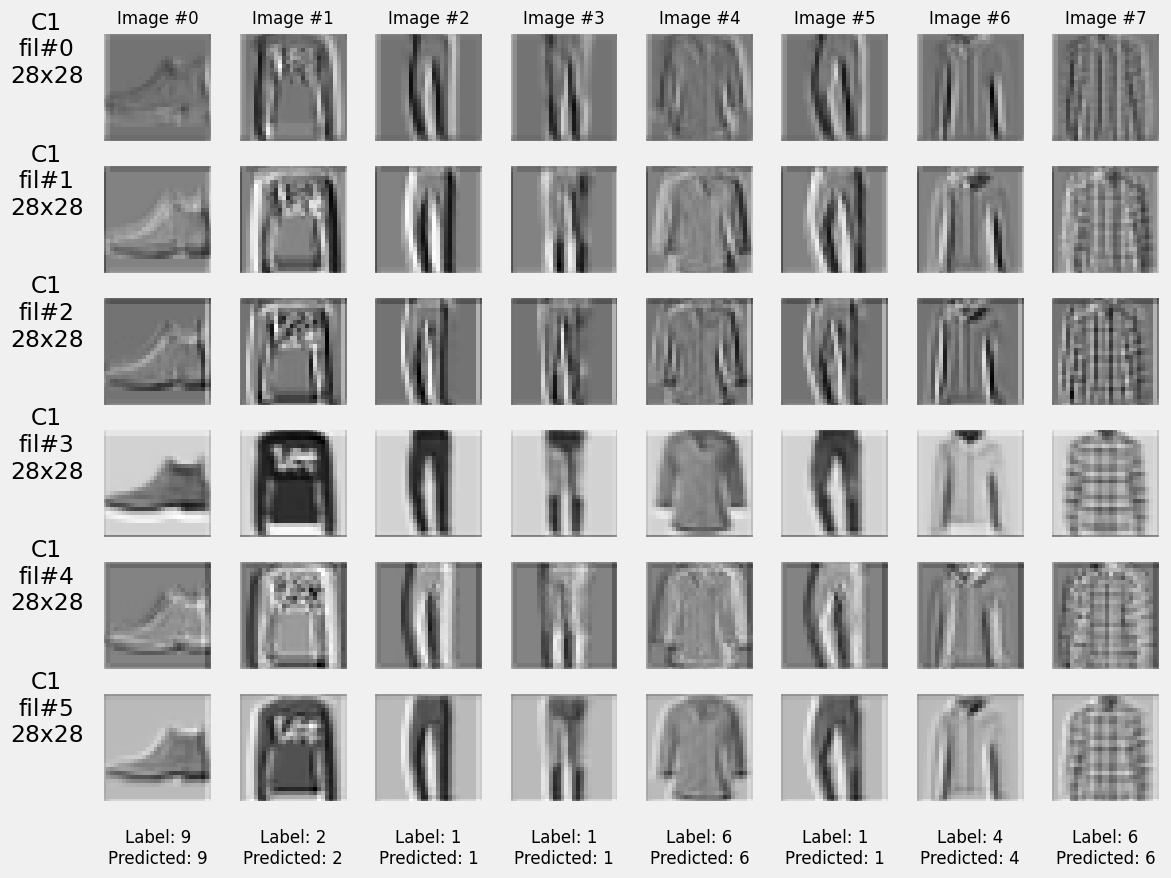

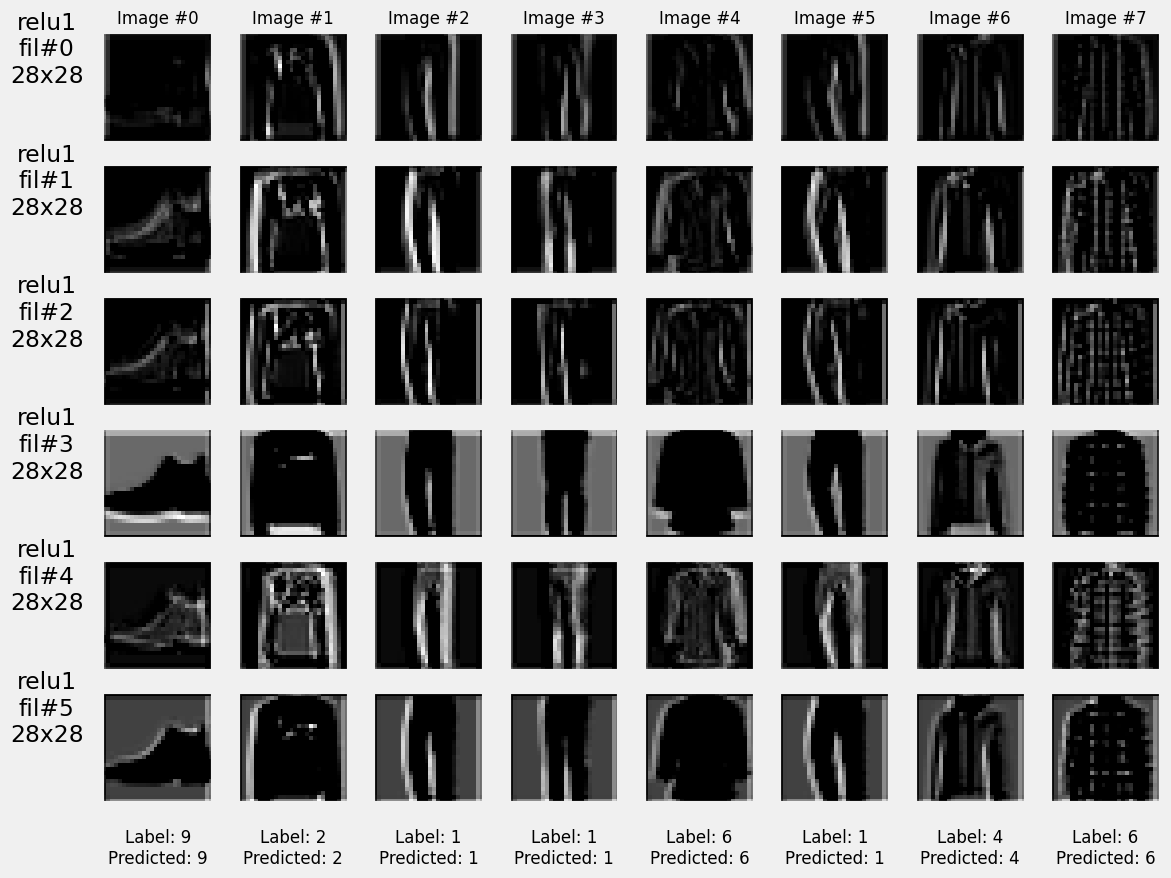

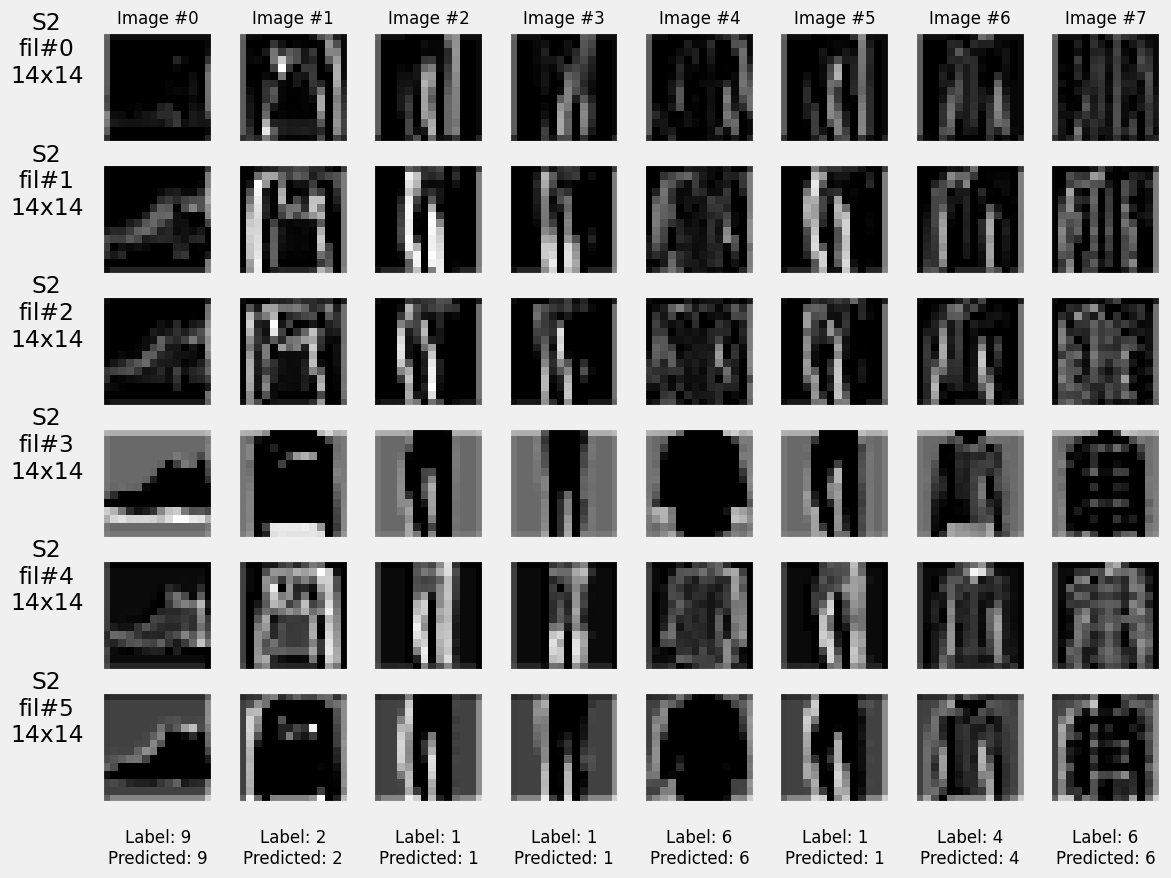

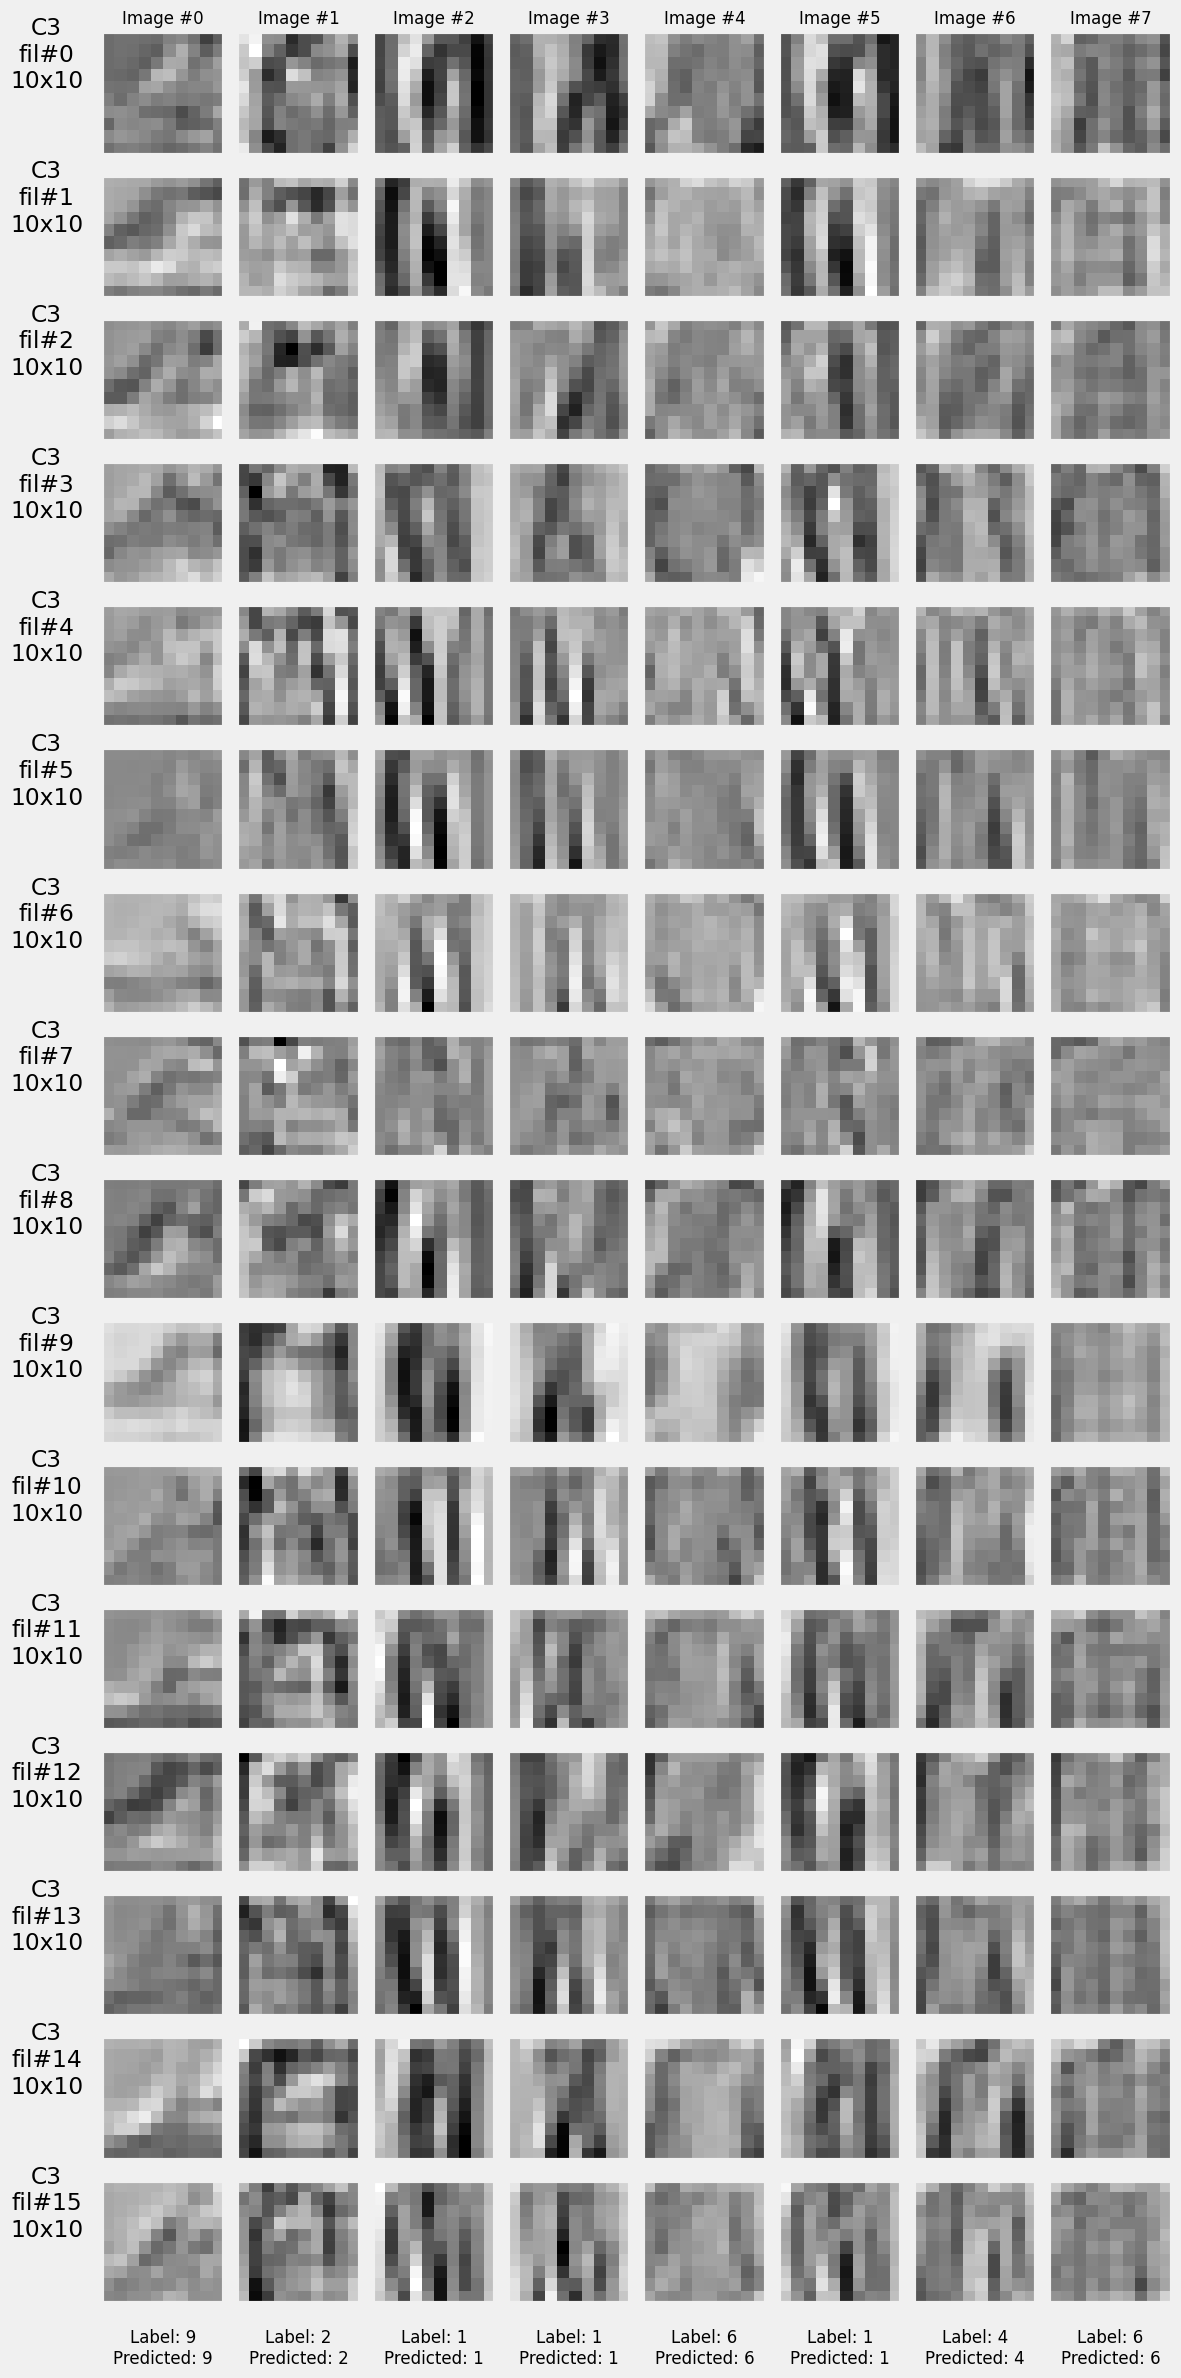

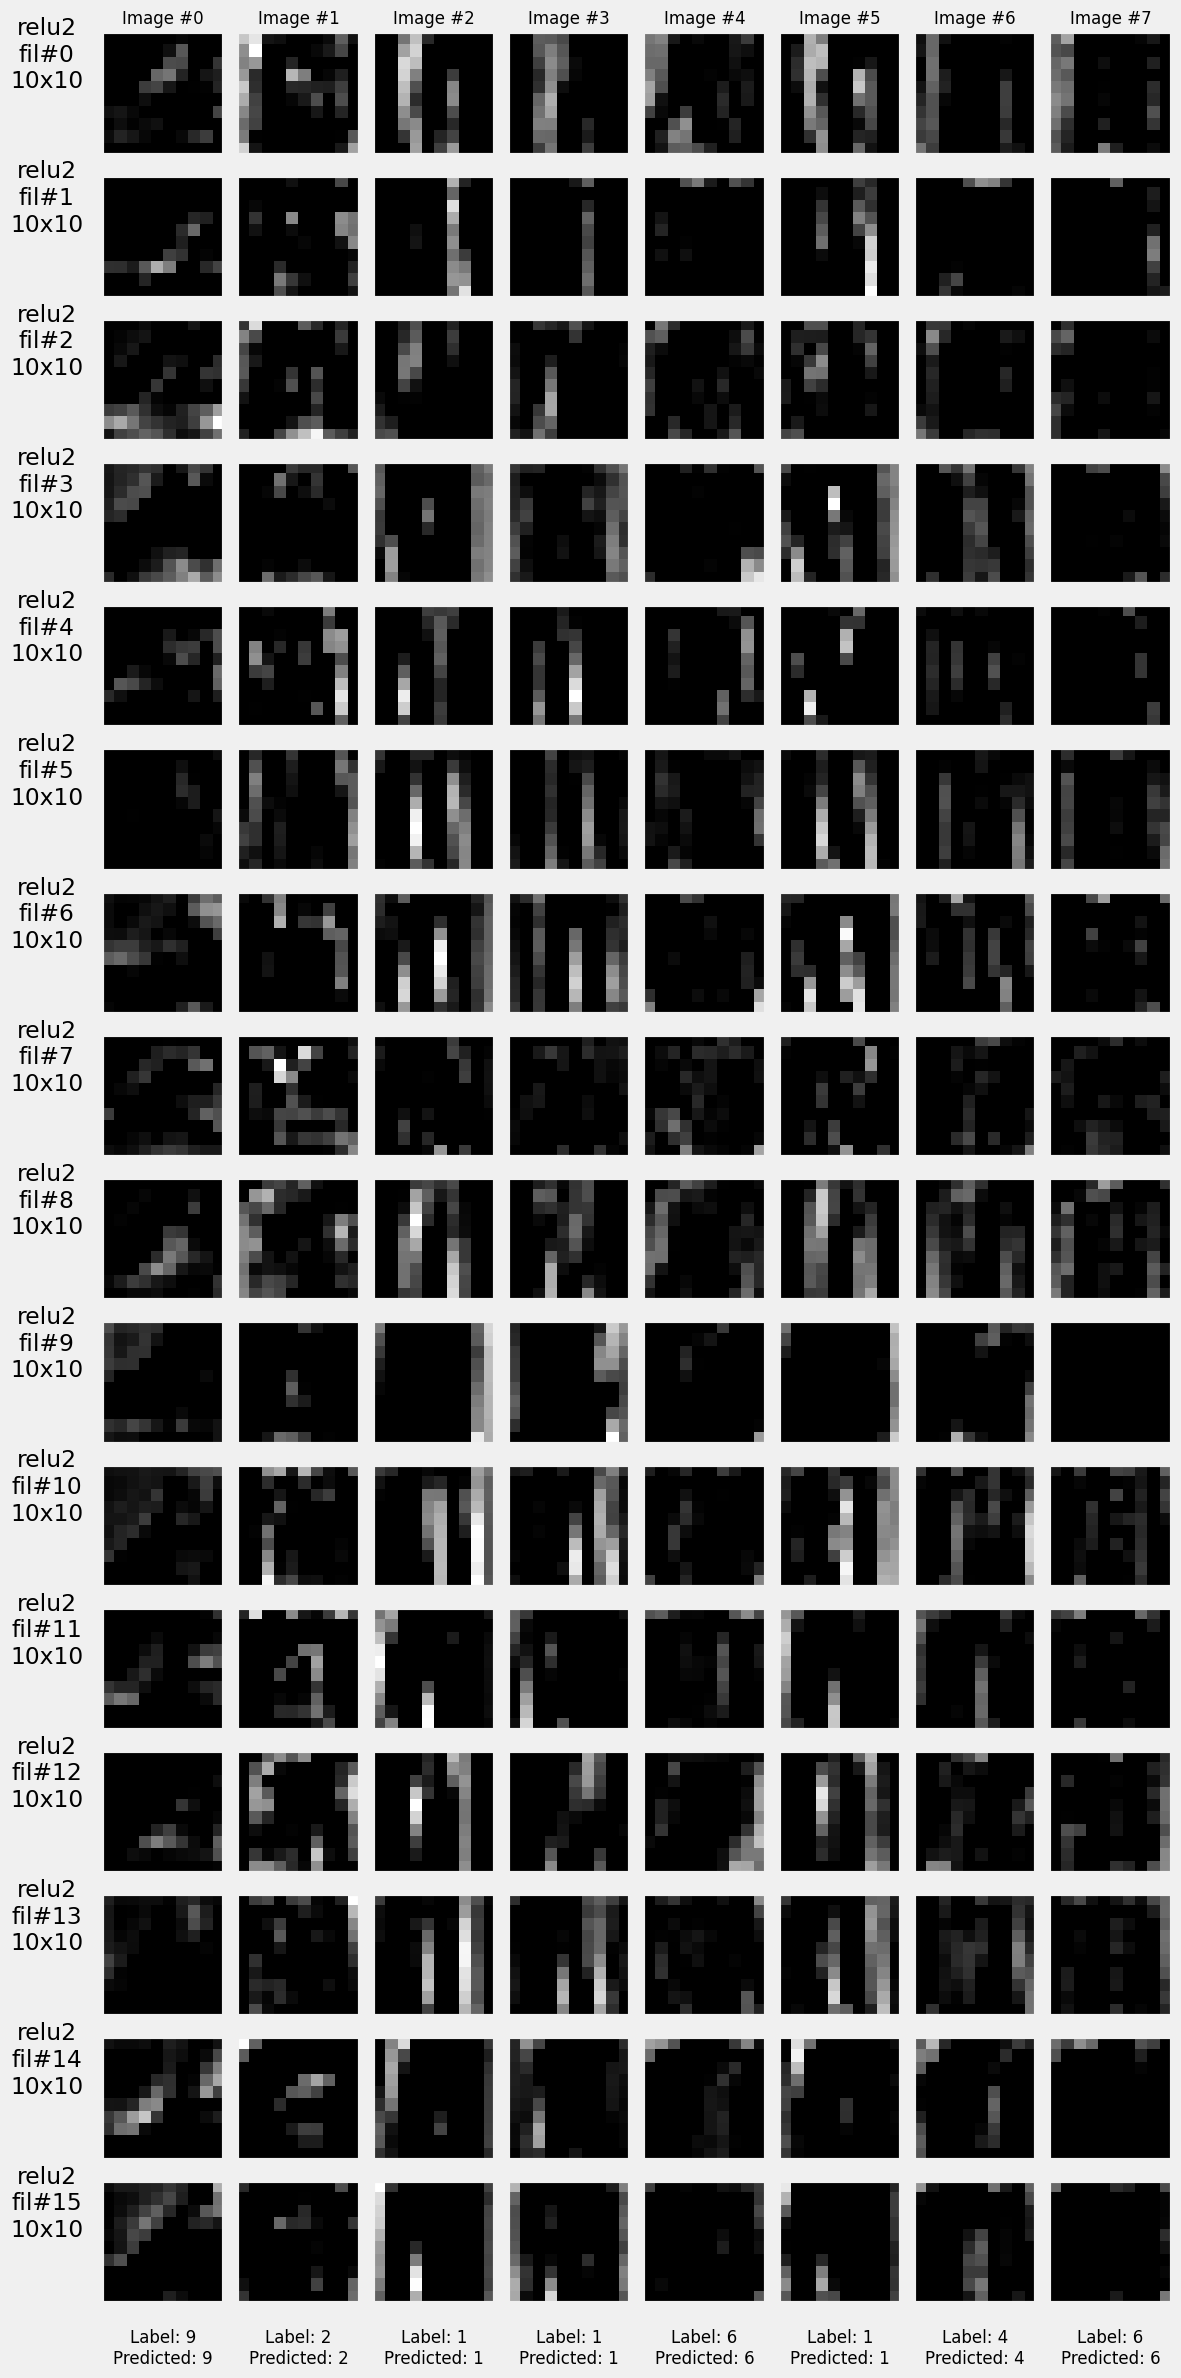

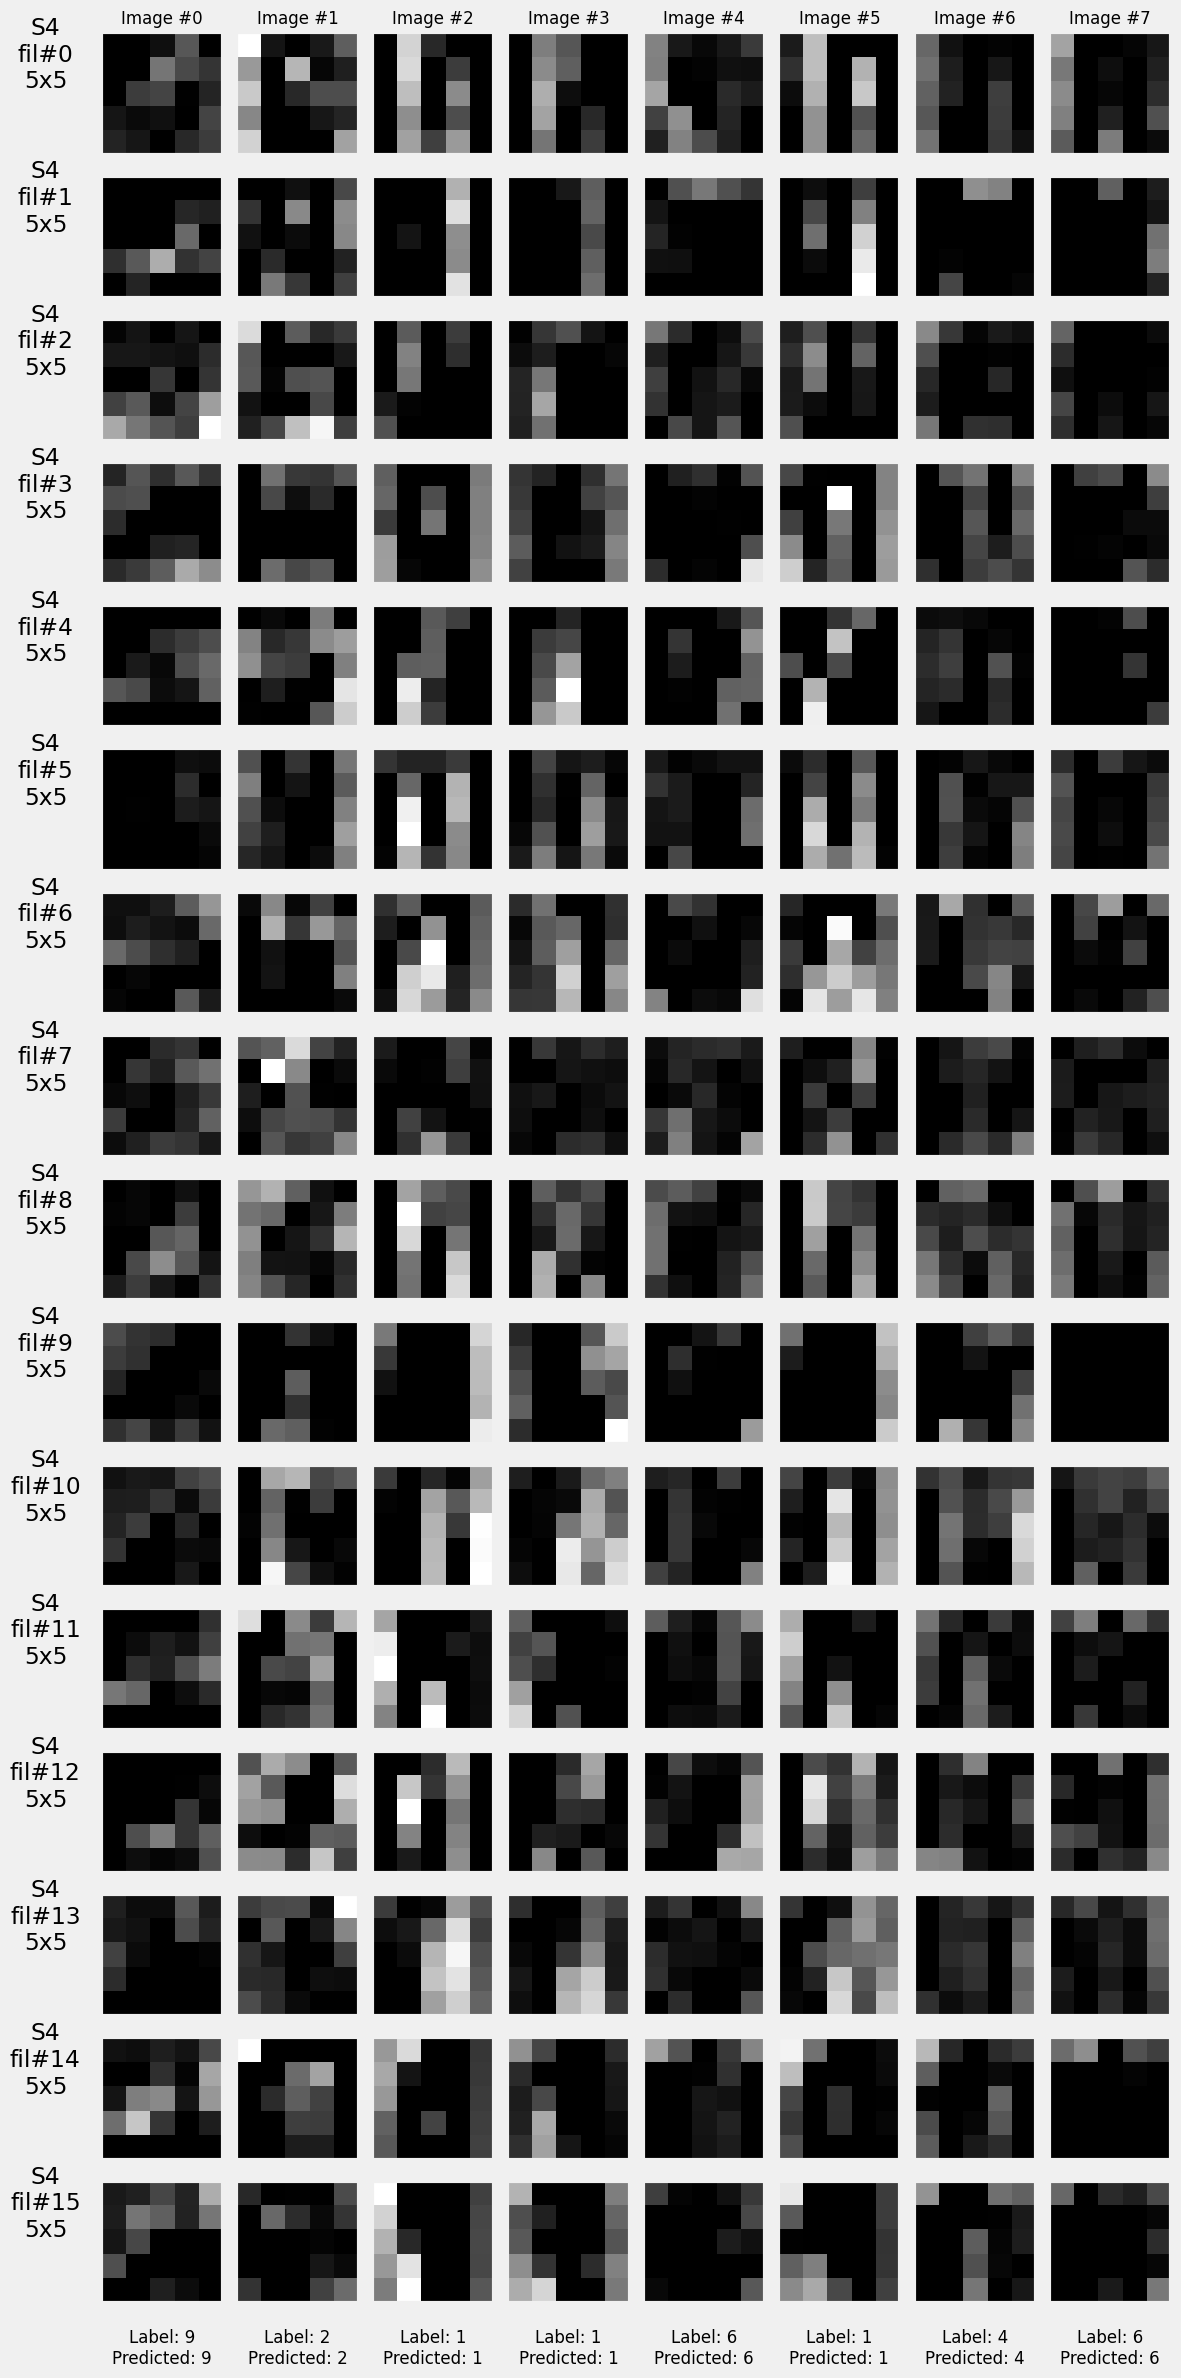

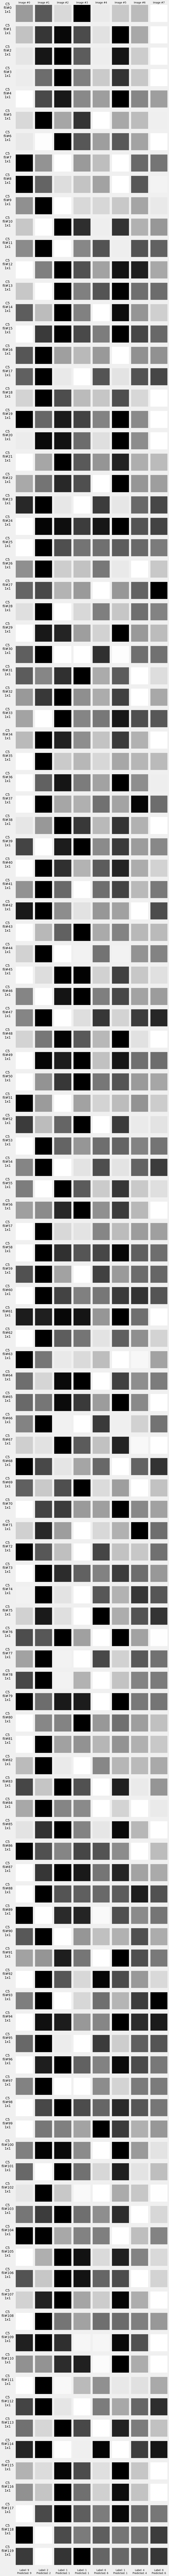

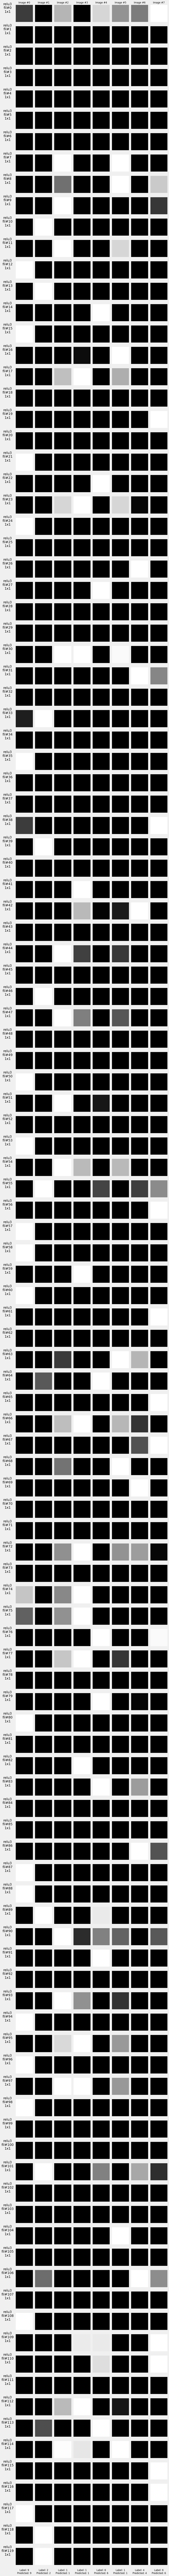

In [57]:
layers_to_hook = ['C1', 'relu1', 'S2', 'C3', 'relu2', 'S4', 'C5', 'relu3']

for layer_name in layers_to_hook:
    arch.attach_hooks([layer_name])

    test_images, test_labels = next(iter(val_loader))
    predictions = arch.predict(test_images.numpy())
    predicted_classes = predictions.argmax(axis=1)

    fig = arch.visualize_outputs(
        layers=[layer_name],
        n_images=8,
        y=test_labels.numpy(),
        yhat=predicted_classes
    )

    plt.savefig(f'img/feature_maps_{layer_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

    arch.remove_hooks()